# Interpreting Random Forests on Heart Disease Data

This notebook explores how to interpret a Random Forest classifier trained to predict heart disease using a real medical dataset.
The main goals are:

- To build a simple but reasonably accurate Random Forest model for heart-disease prediction.   
- To understand which clinical features are most important using feature importance.
- To visualize how individual features affect the model’s predictions using partial dependence plots (PDPs).

Throughout the notebook, explanations aim to be accessible to beginners while still introducing high-level interpretability concepts used in modern machine learning.

To improve accessibility, all plots in this notebook use a color-blind-friendly palette so that readers with common forms of color vision deficiency can distinguish the different classes and curves.


In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn # If needed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import PartialDependenceDisplay

# Use seaborn's colorblind-friendly palette
sns.set(style="whitegrid", palette="colorblind")  # colorblind-friendly categorical palette [web:77][web:79]
plt.rcParams["figure.figsize"] = (7, 5)
RANDOM_STATE = 42


## Dataset: Heart Failure Prediction

The dataset used in this tutorial comes from the Kaggle *Heart Failure Prediction* dataset, which is derived from a heart-disease study and contains 918 patient records. Each row corresponds to one patient, with clinical features such as age, blood pressure, cholesterol, and exercise-related measurements, and a target label `HeartDisease` indicating the presence (1) or absence (0) of heart disease.

This kind of medical prediction task is a realistic and important use case for machine learning, where interpretability is especially critical because predictions can influence clinical decisions.


In [ ]:
# Adjust the path if heart.csv is in a subfolder like "data/heart.csv"
data_path = "heart.csv"

df = pd.read_csv(data_path)
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.info()

print("\nSummary statistics (numeric features):")
display(df.describe())

print("\nClass distribution (HeartDisease):")
print(df["HeartDisease"].value_counts())
print("\nClass distribution (normalized):")
print(df["HeartDisease"].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Summary statistics (numeric features):


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



Class distribution (HeartDisease):
HeartDisease
1    508
0    410
Name: count, dtype: int64

Class distribution (normalized):
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


## Data overview

The dataset contains 918 patients and 12 columns, with 11 input features and one target label `HeartDisease`. All columns are complete (no missing values), and the features include a mix of numeric variables (such as `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`) and categorical variables (such as `Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina`, `ST_Slope`).

The target variable `HeartDisease` is binary, with about 55% of patients labelled as having heart disease and 45% without, so the classes are reasonably balanced for training a classifier.

This makes it a suitable dataset for demonstrating Random Forests and interpretation tools without needing heavy re-sampling techniques.


**Quick EDA plots**

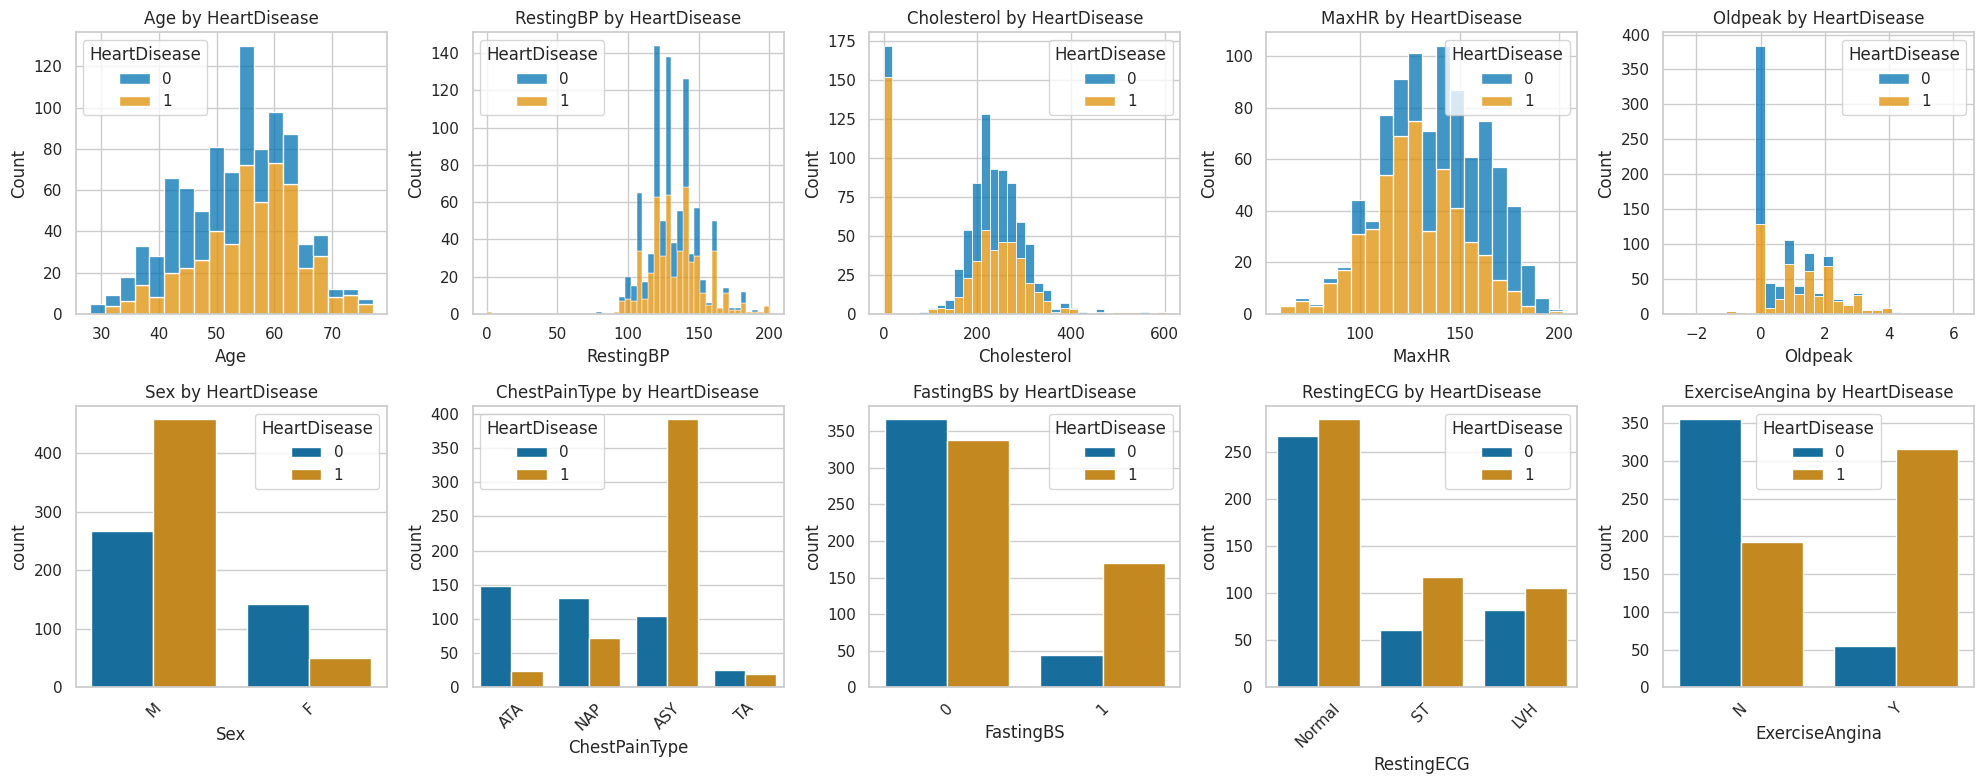

In [ ]:
numeric_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_features = ["Sex", "ChestPainType", "FastingBS", "RestingECG",
                        "ExerciseAngina", "ST_Slope"]

fig, axes = plt.subplots(2, len(numeric_features), figsize=(4*len(numeric_features), 8))

for i, col in enumerate(numeric_features):
    sns.histplot(data=df, x=col, hue="HeartDisease", kde=False,
                 multiple="stack", ax=axes[0, i])
    axes[0, i].set_title(f"{col} by HeartDisease")

for i, col in enumerate(categorical_features[:len(numeric_features)]):
    sns.countplot(data=df, x=col, hue="HeartDisease", ax=axes[1, i])
    axes[1, i].set_title(f"{col} by HeartDisease")
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## First look at the features

The histograms and bar charts show how each feature is distributed for patients with and without heart disease. For example, patients with heart disease tend to be slightly older on average, and they often have lower maximum heart rate values (`MaxHR`) compared to patients without heart disease, which matches medical intuition.

Some categorical features, such as chest pain type and exercise-induced angina, also show clear differences between the two groups.This suggests that a machine learning model like a Random Forest should be able to learn patterns that help distinguish patients with higher and lower heart-disease risk.


**features/target and split into train/test.**

In [ ]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((734, 11), (184, 11))

**Preprocessing and Random Forest pipeline**

In [ ]:
# Define which columns are numeric and which are categorical
numeric_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_features = ["Sex", "ChestPainType", "FastingBS",
                        "RestingECG", "ExerciseAngina", "ST_Slope"]

numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf_clf),
])

model


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('rf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

## Modeling setup

To handle the mix of numeric and categorical features, the model uses a preprocessing pipeline that passes numeric variables through unchanged and one-hot encodes categorical variables. On top of this, a RandomForestClassifier is trained, which builds many decision trees on different subsets of the data and averages their votes to make a final prediction.

Using a pipeline keeps all steps together, making the workflow easier to reuse and reducing the chance of data leakage between training and test sets.

**Train the model**

In [ ]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('rf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

**Accuracy and confusion matrix**

Test accuracy: 0.897


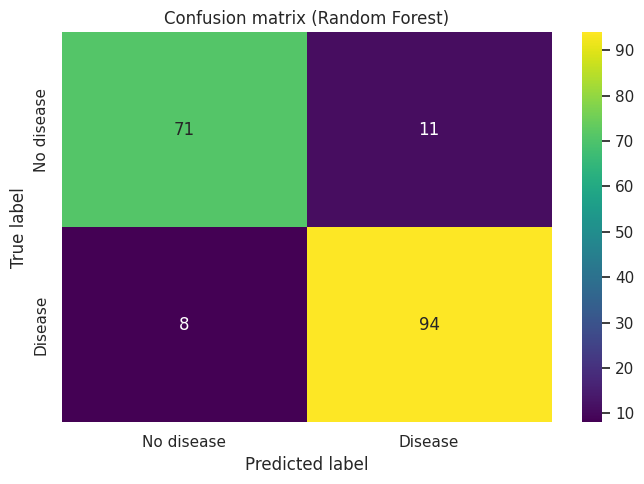


Classification report:

              precision    recall  f1-score   support

  No disease       0.90      0.87      0.88        82
     Disease       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



In [ ]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=["No disease", "Disease"],
    yticklabels=["No disease", "Disease"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix (Random Forest)")
plt.tight_layout()
plt.show()

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["No disease", "Disease"]))


## Model performance

On the held-out test set, the Random Forest classifier reaches an accuracy of about 0.90, meaning it predicts heart disease correctly for roughly 9 out of 10 patients. The confusion matrix shows 71 true negatives, 94 true positives, and relatively few mistakes (11 false positives and 8 false negatives), so the model works reasonably well for both classes.

The classification report confirms this: both the “No disease” and “Disease” classes have precision and recall around 0.87–0.92, with f1-scores close to 0.90. For this tutorial, the goal is not to optimize performance further but to use this reasonably accurate model as a case study for understanding feature importance and partial dependence plots.


**Get transformed feature names**

In [ ]:
# Extract trained RandomForest and preprocessor from the pipeline
rf_trained = model.named_steps["rf"]
preprocessor = model.named_steps["preprocess"]

# Get names of one-hot encoded categorical features
encoded_cat_features = list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
)

all_feature_names = numeric_features + encoded_cat_features

len(all_feature_names), rf_trained.n_features_in_


(21, 21)

**Plot top feature importances**

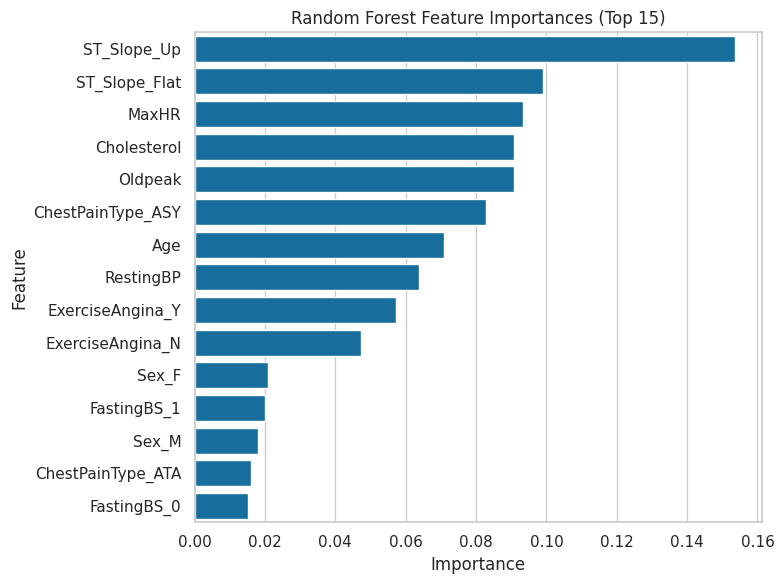

,0
ST_Slope_Up,0.153500
ST_Slope_Flat,0.098945
MaxHR,0.093384
Cholesterol,0.090788
Oldpeak,0.090761
ChestPainType_ASY,0.082783
Age,0.070984
RestingBP,0.063868
ExerciseAngina_Y,0.057194
ExerciseAngina_N,0.047433


In [ ]:
importances = rf_trained.feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

top_n = 15
feat_imp_top = feat_imp.head(top_n)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp_top.values, y=feat_imp_top.index)
plt.title("Random Forest Feature Importances (Top 15)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

feat_imp_top


## Global feature importance

The Random Forest’s feature importance scores show which input variables the model uses most when predicting heart disease. In this model, the strongest signals come from the ST segment slope (`ST_Slope_Up` and `ST_Slope_Flat`), maximum heart rate (`MaxHR`), cholesterol, ST depression (`Oldpeak`), and asymptomatic chest pain type (`ChestPainType_ASY`), followed by age, resting blood pressure, and exercise-induced angina.

Clinically, this makes sense: changes in the ECG ST segment, exercise capacity, and chest pain pattern are key indicators of underlying heart problems, so it is reassuring that the model treats them as important.  However, these importance scores are global summaries that do not tell us *how* each feature affects the prediction, which is why we now turn to partial dependence plots.


**1D Partial Dependence Plots**

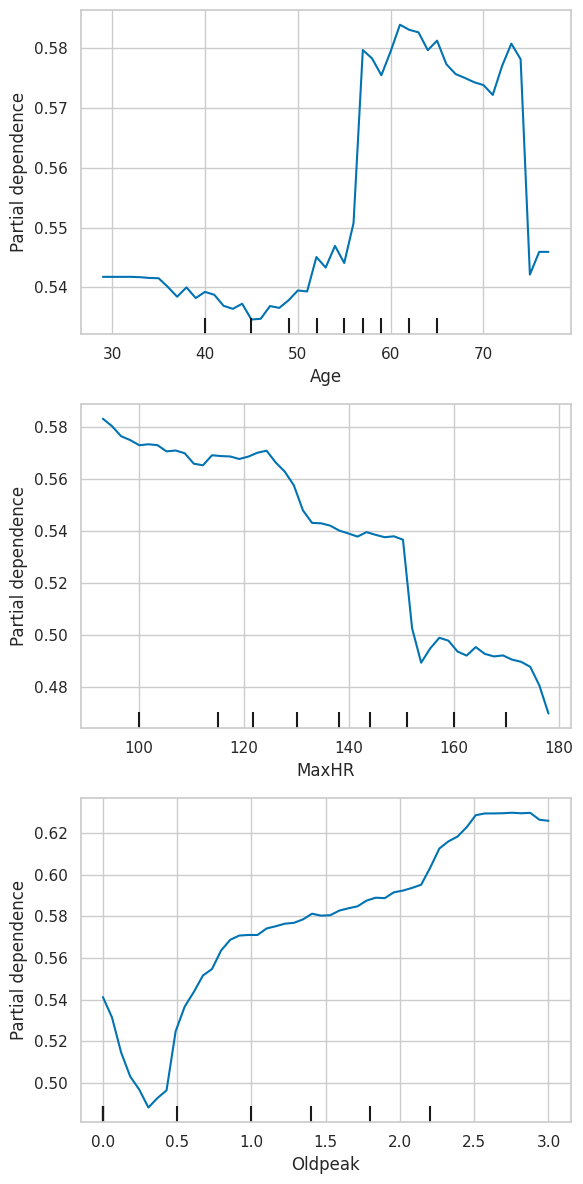

In [ ]:
features_to_plot = ["Age", "MaxHR", "Oldpeak"]

fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(6, 4 * len(features_to_plot)))

for i, feat in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        features=[feat],
        kind="average",
        grid_resolution=50,
        ax=ax[i] if len(features_to_plot) > 1 else ax,
    )
    ax[i].set_ylabel("Predicted probability of heart disease")

plt.tight_layout()
plt.show()


## Partial dependence: how single features affect risk

The partial dependence plot for **Age** shows that the model’s predicted probability of heart disease is slightly lower for patients in their late 30s and early 40s, then rises noticeably for patients in their late 50s and 60s. This matches the medical expectation that older patients tend to be at higher risk of heart problems.

For **MaxHR** (maximum heart rate achieved during exercise), the curve slopes downward: as MaxHR increases from around 100 to 170 beats per minute, the predicted probability of heart disease gradually decreases. This suggests the model has learned that being able to reach a higher heart rate during exercise is usually a sign of better cardiovascular fitness and lower disease risk.

The **Oldpeak** plot (ST depression induced by exercise) shows the opposite pattern: at very low ST depression the predicted risk is lower, but as Oldpeak increases above about 0.5–1.0, the model’s estimated probability of heart disease rises steadily. This is again consistent with cardiology knowledge that larger ST-segment depression during a stress test is associated with more severe ischemia.


**2D partial dependence (Age vs MaxHR)**


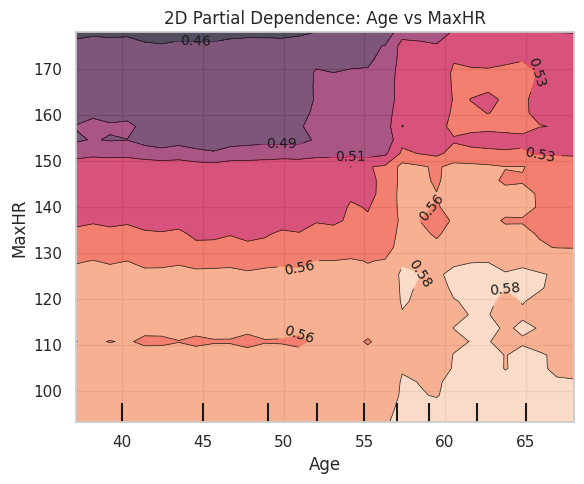

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=[("Age", "MaxHR")],
    kind="average",
    grid_resolution=30,
    ax=ax,
)

plt.title("2D Partial Dependence: Age vs MaxHR")
plt.tight_layout()
plt.show()


## Interaction between age and exercise capacity

The 2D partial dependence plot for **Age** and **MaxHR** shows how these two features interact in the model’s predictions. Lighter regions (higher predicted risk) appear where patients are older and achieve only a relatively low maximum heart rate during exercise, suggesting that the model treats “older age + poor exercise capacity” as a particularly risky combination.

In contrast, darker regions (lower predicted risk) are found where MaxHR is high, especially for younger patients, indicating that good exercise performance can offset some of the risk associated with age. This kind of interaction plot helps move beyond single-feature effects and shows how the Random Forest combines clinical signals when estimating heart-disease probability.


## Limitations and ethical considerations

Although this Random Forest model achieves around 90% accuracy on the test set, it is still only an approximation of reality and can make clinically important mistakes, such as false negatives where a high-risk patient is predicted as low risk. In a real hospital setting, such a model should be used only as a decision-support tool alongside clinical judgment, not as an automatic replacement for doctors’ expertise.

The feature importance scores and partial dependence plots used in this tutorial also have technical limitations. Feature importance based on impurity reduction can overemphasize variables with many possible splits or correlated predictors, while partial dependence plots assume that the feature being varied is independent of the others, which is often not true in medical data. As a result, these visualisations should be interpreted as approximate explanations of the model’s behaviour, not as definitive causal statements about how each clinical variable affects heart-disease risk.

From an ethical perspective, any machine-learning system for healthcare must address issues of bias, privacy, and transparency. Training data may underrepresent certain demographic groups, which can lead to systematically worse performance and unfair treatment for those patients if the model is deployed without careful auditing. At the same time, explainability methods like feature importance and PDPs are valuable because they help clinicians and patients understand and question predictions, supporting informed consent and trust in AI-assisted decisions.

## Conclusion

In this tutorial, a Random Forest classifier was trained on a real heart-disease dataset and reached about 90% accuracy, correctly identifying most patients with and without heart disease. Using a preprocessing pipeline made it straightforward to handle a mix of numeric and categorical clinical features in a reproducible way.

Global feature importance plots showed that the model relies most strongly on ECG-related measures such as ST slope and ST depression, together with maximum heart rate, cholesterol, age, blood pressure, chest pain type, and exercise-induced angina, which aligns well with established cardiology knowledge. Partial dependence plots then provided an intuitive view of how changing a single feature (for example, increasing age or Oldpeak, or decreasing MaxHR) shifts the predicted probability of heart disease, and a 2D PDP revealed how age and exercise capacity interact in the model’s risk estimates.

Overall, this example shows how tree-based models like Random Forests can be combined with interpretation tools to move beyond “black-box” predictions towards explanations that clinicians and beginners can understand. At the same time, the discussion of limitations and ethics highlights that such explanations are only one piece of responsible AI in healthcare, which also requires careful validation, fairness checks, and ongoing human oversight.